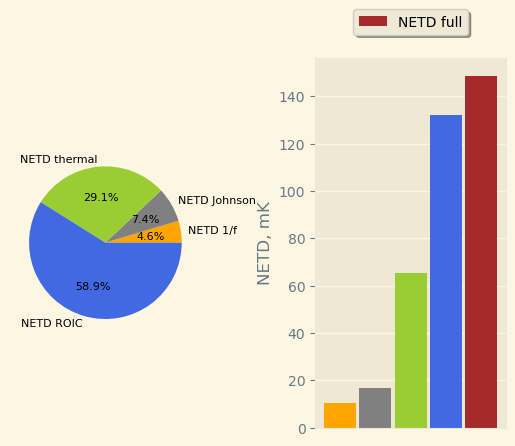

In [1]:
import PySimpleGUI as sg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.colors as mcolors

# constants

c1 = 3.742e8
c2 = 1.439e4
c3 = 1.884e27

# all necessary functions

def get_bb_spc_radiance (wvl, T):
    return c1 / ((wvl**5) * np.exp(c2/(wvl * T)) - 1)

def get_bb_photon_flux (wvl, T):
    return c3 / ((wvl**4) * np.exp(c2/(wvl * T)) - 1)

def get_temp_deriv (wvl, T):
    numerator = c1 * c2 * np.exp(c2 / (wvl * T))
    denominator = (wvl**6) * (T**2) * (np.exp(c2/(wvl * T)) - 1)**2
    return numerator / denominator

def get_flux_deriv (wvl, T):
    return c3 * c2 * np.exp(c2 / (wvl * T)) / ((wvl**5) * (T**2) * np.exp(c2/(wvl * T)) - 1)**2

def get_radiance_contrast (wvl_start, wvl_stop, T, n_samples = 1000):
    lambda_distr = np.linspace(wvl_start, wvl_stop, n_samples)
    delta_wvl = lambda_distr[1] - lambda_distr[0]
    P_distr = [get_temp_deriv(wvl, T) for wvl in lambda_distr]                  
    return delta_wvl * np.sum(P_distr) # radiance contrast in W/(m**2 * K)

def get_comm_mult(f_number, phi, dP_dT, G, beta, A, eps):
    return ((4 * f_number ** 2) / (phi * dP_dT)) * (G / (beta * A * eps)) # common multuplier calculated for all NETD components equally

def get_netd_1f(comm_mult, K, v, xl, fi, fs, w, C, G, TCR):
    return comm_mult * ((K/v) * (np.log(xl * fi /fs)) * (1 + w**2 * (C/G)**2))**0.5 / TCR

def get_netd_johnson(comm_mult, k, T1, Rbol, xl, fi, w, C, G, TCR, Vbias):
    return comm_mult * 2 * k**0.5 * ((T1 * Rbol * xl * fi * (1 + w**2 * (C/G)**2))**0.5)/(TCR * Vbias)

def get_netd_thermal(comm_mult, k, T1, C):
    return comm_mult * k**0.5 * T1 / (C**0.5)

def get_vroic(Rroic, Rbol, Iroic, Vamp, Vq):
    Veff = ((Rroic * Rbol) / (Rroic + Rbol)) * Iroic
    return (Vamp ** 2 + (Vq ** 2 / 12) + Veff**2) ** 0.5

def get_netd_roic(comm_mult, Rroic, Rbol, w, C, G, TCR, Vbias, Vroic):
    Coeff = comm_mult * (Rroic + Rbol) * (1 + w**2 * (C/G)**2)**0.5 / (TCR * Vbias * Rroic)
    return Coeff * Vroic

# All necessary variables

# Required parameters
k = 1.38e-23                          # Boltzmann constant

D_lens = 1.92e-3                      # input apeture size - metalens diameter
focal_length = 2e-3                   # focal distance
F = focal_length / D_lens             # F-number

K = 4e-30
v = 4e-16

G = 3.7e-8                            # total thermal conductance
TCR = 0.025                            # temperature coeffcienct of resistance
w = 30                                 # IR modulation frequency
C = 1e-10                             # thermal capacitance of a single pixel
fi = 20                               # imaging frame rate
fs = 1.66e-2                          # shutter frequency - uniformity correction frequency    
T1 = 300                              # detector temperature
xl = 32                               # amount of lines
xc = 32                               # amount of columns
tau_therm = C/G                       # thermal time constant of a bolometer pixel
fr = xl * fi                          # read-out integration frequency
fbol = 1 / (4 * tau_therm)            # bolometer thermal integration frequency
f_eff = np.min([fr, fbol])

Rbol = 1e5                            # pixel resistivity
Rroic = 1e5                           # input impedance of the ROIC

pixel_size = 12e-6                    # pixel side
A = pixel_size ** 2                   # pixel area
beta = 0.7                            # pixel fill-factor
phi = 0.8                             # optics transmission
eps = 0.9                             # infrared absroption rate of the bolometer membrane

lambda_start = 8
lambda_r = 12   

Vbias = 2
Vq = 2e-6
Vamp = 0.8e-6
Vadc = Vq/(12**0.5)
Reff = (Rbol*Rroic)/(Rbol + Rroic)
Iroic = 8e-11

dP_dT = get_radiance_contrast(lambda_start, lambda_r, T1)

# VARS CONSTS:
# Upgraded dataSize to global...
_VARS = {'window': False,
         'fig_agg': False,
         'pltFig': False,
         'dataSize': 60}

# visualization parameters

vis_params = {'labels':('NETD 1/f',
                        'NETD Johnson',
                        'NETD thermal',
                        'NETD ROIC',
                        'NETD full'),
             'colors':(mcolors.CSS4_COLORS['orange'],
                       mcolors.CSS4_COLORS['grey'],
                       mcolors.CSS4_COLORS['yellowgreen'],
                       mcolors.CSS4_COLORS['royalblue'],
                       mcolors.CSS4_COLORS['brown'])}

plt.style.use('Solarize_Light2')

# Helper Functions

def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg


# \\  -------- PYSIMPLEGUI -------- //

AppFont = 'Any 16'
SliderFont = 'Any 14'
sg.theme('black')

# New layout with slider and padding

layout = [[sg.Canvas(key='figCanvas', background_color='#FDF6E3')],
          [sg.Text(text="C - Pixel heat capacity:                                                 ",
                   font=SliderFont,
                   background_color='#FDF6E3',
                   pad=((0, 0), (0, 0)),
                   text_color='Black'),
           sg.Slider(range=(5e-11, 1e-9), resolution = 1e-11,orientation='h', size=(34, 20),
                     default_value=5e-11,
                     background_color='#FDF6E3',
                     text_color='Black',
                     key='C',
                     enable_events=True)],
          
          [sg.Text(text="G - Pixel heat conduction:                                           ",
                   font=SliderFont,
                   background_color='#FDF6E3',
                   pad=((10, 0), (0, 0)),
                   text_color='Black'),
           sg.Slider(range=(1e-8, 1e-7), resolution = 1e-9,orientation='h', size=(34, 20),
                     default_value=1e-8,
                     background_color='#FDF6E3',
                     text_color='Black',
                     key='G',
                     enable_events=True)],
          
            [sg.Text(text="Rbol/Rroic - Pixel resistivity/ROIC input impedance:",
                   font=SliderFont,
                   background_color='#FDF6E3',
                   pad=((10, 0), (0, 0)),
                   text_color='Black'),
           sg.Slider(range=(1e4, 1e6), resolution = 1e4,orientation='h', size=(34, 20),
                     default_value=1e4,
                     background_color='#FDF6E3',
                     text_color='Black',
                     key='R',
                     enable_events=True)],
          
          # pad ((left, right), (top, bottom))
          [sg.Button('Exit', font=AppFont, pad=((540, 0), (0, 0)))]]

_VARS['window'] = sg.Window('Random Samples',
                            layout,
                            finalize=True,
                            resizable=True,
                            location=(100, 100),
                            element_justification="center",
                            background_color='#FDF6E3')

def drawChart():
    _VARS['pltFig'] = plt.figure()
      
    data_initial = 40e-3, 20e-3, 50e-3, 40e-3, 200e-3
    plt.subplot(1,2,1)
    plt.pie(data_initial[0:4], labels = vis_params['labels'][0:4],autopct='%1.1f%%', colors = vis_params['colors'][0:4], textprops={'fontsize': 8})

    # Create barplot
    plt.subplot(1,2,2)
            
    for i in range(4):
        plt.bar(i, 1e3 * data_initial[i], width = 0.9, color = vis_params['colors'][i])
    plt.bar(4, 1e3 * data_initial[4], width = 0.9, color = vis_params['colors'][4], label=vis_params['labels'][4])     
        
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=None)
    plt.ylabel('NETD, mK')
    plt.xticks([]) 
    _VARS['fig_agg'] = draw_figure(
        _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig'])

def updateChart(all_netd):
    _VARS['fig_agg'].get_tk_widget().forget()

    plt.clf()

    plt.subplot(1,2,1)
    plt.pie(all_netd[0:4], labels = vis_params['labels'][0:4],autopct='%1.1f%%', colors = vis_params['colors'][0:4], textprops={'fontsize': 8})
    plt.subplot(1,2,2)  
    for i in range(4):
        plt.bar(i, 1e3 * all_netd[i], width = 0.9, color = vis_params['colors'][i])
    plt.bar(4, 1e3 * all_netd[4], width = 0.9, color = vis_params['colors'][4], label=vis_params['labels'][4])    
    plt.ylabel('NETD, mK')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=None)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fancybox=True, shadow=True)
    plt.xticks([]) 
    _VARS['fig_agg'] = draw_figure(
        _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig'])

def updateData(values):
    
    C = values['C']
    G = values['G']
    Rbol = values['R']
    Rroic = values['R']
    
    comm_mult = get_comm_mult(F, phi, dP_dT, G, beta, A, eps)
    NETD_1_f = get_netd_1f(comm_mult, K, v, xl, fi, fs, w, C, G, TCR)
    NETD_johnson = get_netd_johnson(comm_mult, k, T1, Rbol, xl, fi, w, C, G, TCR, Vbias)
    NETD_thermal = get_netd_thermal(comm_mult, k, T1, C)  
    Vroic = get_vroic(Rroic, Rbol, Iroic, Vamp, Vq)
    NETD_roic = get_netd_roic(comm_mult, Rroic, Rbol, w, C, G, TCR, Vbias, Vroic)
    NETD_full = (NETD_1_f**2 + NETD_johnson**2 + NETD_thermal**2 + NETD_roic**2)**0.5
    
    all_netd = NETD_1_f, NETD_johnson, NETD_thermal, NETD_roic, NETD_full
    updateChart(all_netd)

drawChart()

# MAIN LOOP
while True:
    event, values = _VARS['window'].read(timeout=200)
    
    if event == sg.WIN_CLOSED or event == 'Exit':
        break
    elif event == 'Resample':
        updateChart()
    elif event == 'C':
        updateData(values)
    elif event == 'G':
        updateData(values)
    elif event == 'R':
        updateData(values)
_VARS['window'].close()